In [1]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


In [2]:
import tensorflow as tf
tf.__version__

D0518 07:03:24.844141181      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0518 07:03:24.844174386      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0518 07:03:24.844177785      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0518 07:03:24.844180203      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0518 07:03:24.844182240      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0518 07:03:24.844184735      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0518 07:03:24.844187177      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0518 07:03:24.

'2.12.0'

In [3]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCH=60

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/plant-village/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [6]:
class_names=dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
len(dataset)

645

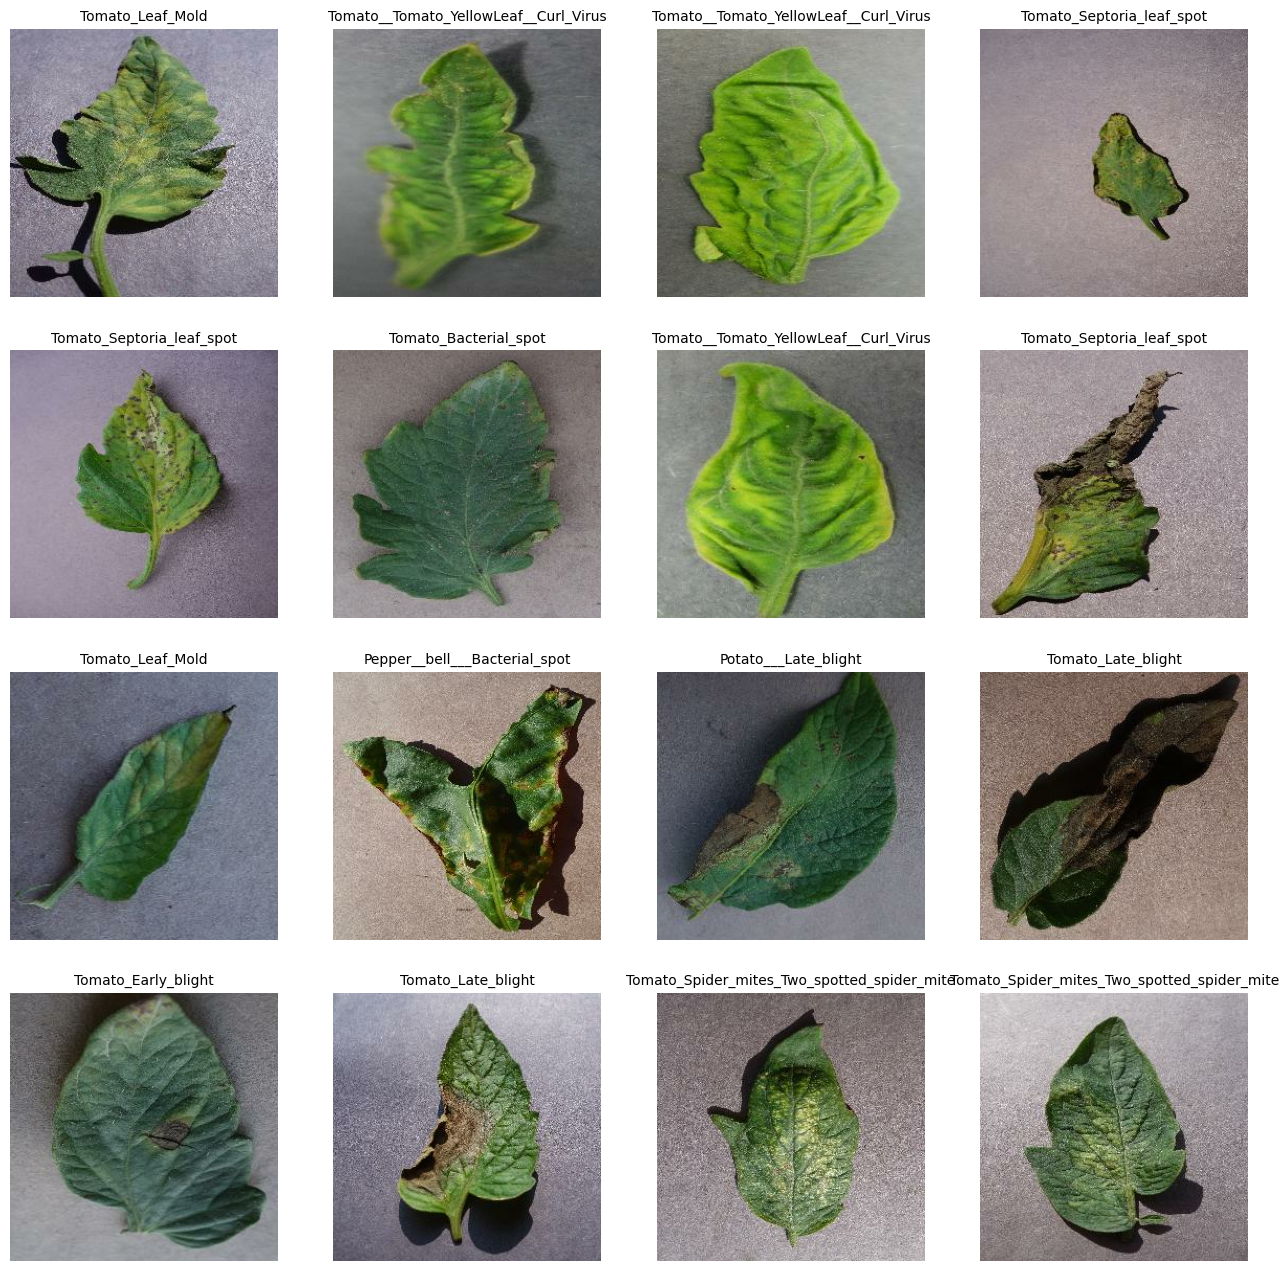

In [8]:
plt.figure(figsize=(16,16))
for image_batch,label_batch in dataset.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]],fontsize=10)
    plt.axis("off")

In [9]:
print(len(dataset))
train_size=0.8
len(dataset)*train_size

645


516.0

In [10]:
train_dataset=dataset.take(511)
len(train_dataset)

511

In [11]:
test_dataset=dataset.skip(511)
len(test_dataset)

134

In [12]:
val_size=0.1
len(dataset)*val_size

64.5

In [13]:
val_dataset=test_dataset.take(64)
len(val_dataset)

64

In [14]:
test_dataset=test_dataset.skip(64)
len(test_dataset)

70

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size=len(dataset)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

 
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
  
    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return  train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

516

In [18]:
len(test_ds)

65

In [19]:
len(val_ds)

64

In [20]:
train_ds=train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=15
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy( from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/60
516/516 [==============================] - 285s 541ms/step - loss: 2.1278 - accuracy: 0.2979 - val_loss: 1.6707 - val_accuracy: 0.4502
Epoch 2/60
516/516 [==============================] - 276s 535ms/step - loss: 1.2990 - accuracy: 0.5684 - val_loss: 1.0486 - val_accuracy: 0.6450
Epoch 3/60
516/516 [==============================] - 280s 542ms/step - loss: 0.7801 - accuracy: 0.7316 - val_loss: 0.6613 - val_accuracy: 0.7744
Epoch 4/60
516/516 [==============================] - 280s 542ms/step - loss: 0.5712 - accuracy: 0.8036 - val_loss: 0.7777 - val_accuracy: 0.7305
Epoch 5/60
516/516 [==============================] - 278s 538ms/step - loss: 0.4713 - accuracy: 0.8412 - val_loss: 0.7432 - val_accuracy: 0.7573
Epoch 6/60
516/516 [==============================] - 278s 539ms/step - loss: 0.4156 - accuracy: 0.8556 - val_loss: 0.4069 - val_accuracy: 0.8516
Epoch 7/60
516/516 [==============================] - 280s 543ms/step - loss: 0.3500 - accuracy: 0.8757 - val_loss: 0.4040 -

In [ ]:
history.history.keys()

In [ ]:
scores=model.evaluate(test_ds)

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCH),acc,label='Training Accuracy')
plt.plot(range(EPOCH),val_acc,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(EPOCH),loss,label='Training Loss')
plt.plot(range(EPOCH),val_loss,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
for images_batch,labels_batch in test_ds.take(1):
  first_image=images_batch[0].numpy().astype('uint8')
  first_label=labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actyal label is:", class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions=model.predict(img_array)

  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class,confidence

In [ ]:
plt.figure(figsize=(14,14))
for images,labels in test_ds.take(1):
  for i in range(9):
    x=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class,confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]

    plt.title(f"Actual:{actual_class},\n Preddicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis("off")

In [ ]:
#Saving The model
#model.save("/kaggle/working/custom.h5")

In [ ]:
#from tensorflow import keras
#model_d=keras.models.load_model("/kaggle/working/custom.h5")

In [ ]:
import tensorflow as tf
#tf.keras.utils.plot_model(model_d, to_file='/kaggle/working/plot_Custom.png', show_shapes=True, show_layer_names=True)